In [1]:
# parse
import re
loss_regex = r"Average loss: (\d+\.\d+)"
acc_regex = r"Accuracy: (\d+\/\d+)"
comp_regex = r"Bandwidth savings: from \d+ to \d+ \((\d+\.\d+)x\)"

def parse(file, regex):
    nums = []
    for line in open(file, "r").readlines():
        matches = re.search(regex, line)
        if matches:
            nums.append(float(eval(matches.group(1))))
    return nums

def parse_loss(file):
    return parse(file, acc_regex)

def parse_comp_ratio(file):
    return parse(file, comp_regex)


## Plot Allreduce Baseline vs Decentralized (Bagua) vs RelaySGD (binary tree topology)

In [15]:
from os import listdir
import pandas as pd

data = {
    "loss": [],
    "name": []
}

files = [file for file in listdir("../logs") if "cifar" in file and "6" in file and "top" not in file]
files.sort(reverse=True)

for name in files:
    file = f"../logs/{name}"
    attrs = {}
    data["loss"].append(parse_loss(file))

    name = name.removeprefix('cifar_')
    name = name.removesuffix('.log')

    if "relay" in name:
        name = "RelaySGD"
    elif "allreduce" in name:
        name = "Allreduce Baseline"
    elif "decentralized" in name:
        name = "Decantralized (Bagua)"

    data["name"].append(name)
    

df = pd.DataFrame(data)
df

,loss,name
0,"[0.1, 0.2157, 0.2254, 0.3408, 0.4923, 0.5527, ...",RelaySGD
1,"[0.1354, 0.1625, 0.1439, 0.1725, 0.1625, 0.153...",Decantralized (Bagua)
2,"[0.2883, 0.4193, 0.5084, 0.592, 0.6548, 0.6943...",Allreduce Baseline


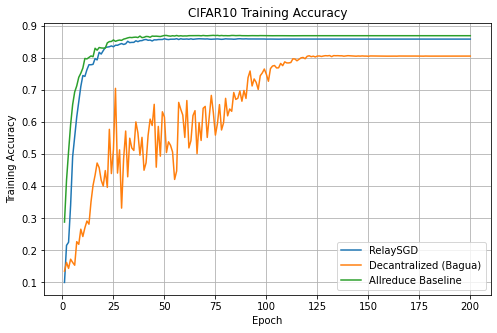

In [16]:
import numpy as np
import matplotlib.pyplot as plt
    
num_epochs = None

plt.figure(figsize=(8, 5)) 
for i, row in df.iterrows():
    row_iters = len(row["loss"])
    if num_epochs is None: num_epochs = row_iters
    else: assert row_iters == num_epochs, "number of its should be consistent"
    t = np.arange(1, num_epochs + 1)
    plt.plot(t, row["loss"], label=row["name"])

plt.title(f"CIFAR10 Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
#plt.ylim(0.5, 0.9)
#plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()

## Plot different topologies of RelaySGD against each other

In [12]:
# Different Topologies
from os import listdir
import pandas as pd

data = {
    "loss": [],
    "name": []
}

files = [file for file in listdir("../logs") if "cifar" in file and "6" in file and "relay" in file]
files.sort(reverse=True)

for name in files:
    file = f"../logs/{name}"
    attrs = {}
    data["loss"].append(parse_loss(file))

    name = name.removeprefix('mnist_')
    name = name.removesuffix('.log')
    if "rand" in name:
        name = "Random Binary Tree"
    elif "dbt" in name:
        name = "Double Binary Trees"
    elif "chain" in name:
        name = "Chain"
    else:
        name = "Binary Tree"

    data["name"].append(name)
    

df = pd.DataFrame(data)
df

,loss,name
0,"[0.2039, 0.2063, 0.348, 0.4265, 0.5289, 0.6288...",Random Binary Tree
1,"[0.2034, 0.2439, 0.3788, 0.5202, 0.5773, 0.603...",Double Binary Trees
2,"[0.1, 0.2157, 0.2254, 0.3408, 0.4923, 0.5527, ...",Binary Tree


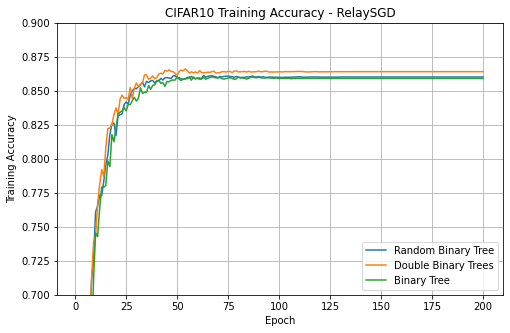

In [13]:
import numpy as np
import matplotlib.pyplot as plt
    
num_epochs = None

plt.figure(figsize=(8, 5)) 
for i, row in df.iterrows():
    row_iters = len(row["loss"])
    if num_epochs is None: num_epochs = row_iters
    else: assert row_iters == num_epochs, "number of its should be consistent"
    t = np.arange(1, num_epochs + 1)
    plt.plot(t, row["loss"], label=row["name"])

plt.title(f"CIFAR10 Training Accuracy - RelaySGD")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.ylim(0.7, 0.9)
#plt.yscale("log")
plt.grid(True)
plt.legend()
plt.show()